In [170]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt

In [3]:
points = pd.read_csv("../data/flowchart-data/charting-m-points.csv", encoding='unicode_escape')

/Users/damien/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
points

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,2,0,0,0.0,0.0,15-0,1 (2),1,0,...,NaN,False,False,False,False,False,False,1,1,1
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,3,0,0,0.0,0.0,30-0,1 (3),1,0,...,1.0,False,False,False,True,False,False,1,1,1
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,4,0,0,0.0,0.0,40-0,1 (4),1,0,...,NaN,True,False,False,False,False,False,1,1,1
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,5,0,0,1.0,0.0,0-0,2 (1),1,0,...,1.0,False,False,False,False,True,False,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619642,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,247,2,2,4.0,3.0,0-40,46 (4),0,0,...,NaN,False,False,False,False,False,False,1,0,1
619643,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,248,2,2,5.0,3.0,0-0,47 (1),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619644,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,249,2,2,5.0,3.0,15-0,47 (2),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619645,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,250,2,2,5.0,3.0,30-0,47 (3),0,0,...,NaN,False,False,False,False,False,False,1,1,1


### plan

go through each match and keep a column for who won each individual point. also who was serving for each point. so make a separate table out of this and then we can try making one with features for the last 10, etc.

oh also we should keep a column for who was in the match

In [101]:
trimmed = points[points["match_id"] > "1991"][["match_id", "PtWinner", "isSvrWinner"]]
trimmed["p1Win"] = trimmed["PtWinner"] == 1
trimmed["isSvrWinner"] = trimmed["isSvrWinner"] == 1
trimmed["p1Served"] = trimmed["p1Win"] == trimmed["isSvrWinner"]
del(trimmed["PtWinner"])

In [102]:
points_dict = trimmed.to_dict("records")
points_dict

[{'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': False,
  'p1Served': 

In [103]:
current_match = ""
p1Win_p1Served = 0
p1Win_p2Served = 0
p2Win_p1Served = 0
p2Win_p2Served = 0
last5_p1Served = []
last5_p2Served = []

for p in points_dict:
  if p["match_id"] != current_match:
    p1Win_p1Served = 0
    p1Win_p2Served = 0
    p2Win_p1Served = 0
    p2Win_p2Served = 0
    last5_p1Served = [None] * 5
    last5_p2Served = [None] * 5
    current_match = p["match_id"]
  p["p1Win_p1Served"] = p1Win_p1Served
  p["p1Win_p2Served"] = p1Win_p2Served
  p["p2Win_p1Served"] = p2Win_p1Served
  p["p2Win_p2Served"] = p2Win_p2Served
  p["p1Served1"] = last5_p1Served[-1]
  p["p1Served2"] = last5_p1Served[-2]
  p["p1Served3"] = last5_p1Served[-3]
  p["p1Served4"] = last5_p1Served[-4]
  p["p1Served5"] = last5_p1Served[-5]
  p["p2Served1"] = last5_p2Served[-1]
  p["p2Served2"] = last5_p2Served[-2]
  p["p2Served3"] = last5_p2Served[-3]
  p["p2Served4"] = last5_p2Served[-4]
  p["p2Served5"] = last5_p2Served[-5]
  if p["p1Served"]:
    last5_p1Served.append(p["p1Win"])
    p1Win_p1Served += p["p1Win"]
    p2Win_p1Served += not p["p1Win"]
    last5_p1Served.pop(0)
  else:
    last5_p2Served.append(p["p1Win"])
    p1Win_p2Served += p["p1Win"]
    p2Win_p2Served += not p["p1Win"]
    last5_p2Served.pop(0)

In [114]:
with_last5 = pd.DataFrame.from_dict(points_dict)
with_last5

,match_id,isSvrWinner,p1Win,p1Served,p1Win_p1Served,p1Win_p2Served,p2Win_p1Served,p2Win_p2Served,p1Served1,p1Served2,p1Served3,p1Served4,p1Served5,p2Served1,p2Served2,p2Served3,p2Served4,p2Served5
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,0,0,0,0,None,None,None,None,None,None,None,None,None,None
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,1,0,0,0,True,None,None,None,None,None,None,None,None,None
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,2,0,0,0,True,True,None,None,None,None,None,None,None,None
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,3,0,0,0,True,True,True,None,None,None,None,None,None,None
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,True,False,4,0,0,0,True,True,True,True,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619642,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,False,True,False,73,48,50,75,True,True,True,True,True,True,True,True,False,False
619643,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,73,49,50,75,True,True,True,True,True,True,True,True,True,False
619644,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,74,49,50,75,True,True,True,True,True,True,True,True,True,False
619645,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,75,49,50,75,True,True,True,True,True,True,True,True,True,False


In [115]:
with_last5 = with_last5.dropna(axis=0, how="any")

In [116]:
serve_agg = with_last5.groupby("match_id").max(["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"])

In [117]:
serve_sums = serve_agg[["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"]].sum()

the serving player wins about 64% of the time, basically

In [118]:
(serve_sums[0] + serve_sums[3]) / sum(serve_sums)

0.6399972080097655

In [119]:
win_pct = with_last5.copy()
win_pct["pct_p1Served"] = (win_pct["p1Win_p1Served"] + 6.4) / (win_pct["p1Win_p1Served"] + win_pct["p2Win_p1Served"] + 10)
win_pct["pct_p2Served"] = (win_pct["p1Win_p2Served"] + 3.6) / (win_pct["p1Win_p2Served"] + win_pct["p2Win_p2Served"] + 10)
del(win_pct["p1Win_p1Served"])
del(win_pct["p2Win_p1Served"])
del(win_pct["p1Win_p2Served"])
del(win_pct["p2Win_p2Served"])
win_pct

,match_id,isSvrWinner,p1Win,p1Served,p1Served1,p1Served2,p1Served3,p1Served4,p1Served5,p2Served1,p2Served2,p2Served3,p2Served4,p2Served5,pct_p1Served,pct_p2Served
17,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,False,True,False,True,True,True,True,False,False,True,False,False,0.693333,0.390909
18,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,False,True,False,False,True,True,True,False,False,True,False,False,0.650000,0.390909
19,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,False,True,False,False,False,True,True,False,False,True,False,False,0.611765,0.390909
20,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,False,False,False,False,False,False,True,False,False,True,False,False,0.577778,0.390909
21,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,False,False,False,False,False,False,True,False,False,False,True,False,0.577778,0.373913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619642,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,False,True,False,True,True,True,True,True,True,True,True,False,False,0.596992,0.387970
619643,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,True,True,True,True,True,True,True,True,True,False,0.596992,0.392537
619644,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,True,True,True,True,True,True,True,True,True,False,0.600000,0.392537
619645,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,True,True,True,True,True,True,True,True,True,True,True,True,False,0.602963,0.392537


In [128]:
win_pct_np = win_pct.iloc[:, 1:].to_numpy("float")

In [159]:
win_pct_np
y = win_pct_np[:, 1]
x_seq = win_pct_np[:, 2:]
x_no_seq = win_pct_np[:, [2, 13, 14]]

In [164]:
linear_seq = LinearRegression().fit(x_seq[:400000], y[:400000])
linear_no_seq = LinearRegression().fit(x_no_seq[:400000], y[:400000])
log_seq = LogisticRegression().fit(x_seq[:400000], y[:400000])
log_no_seq = LogisticRegression().fit(x_no_seq[:400000], y[:400000])

In [188]:
np.mean(np.square(y[400000:] - log_seq.predict_proba(x_seq[400000:, ])[:, 1]))

0.23004220095770053

In [189]:
np.mean(np.square(y[400000:] - log_no_seq.predict_proba(x_no_seq[400000:, ])[:, 1]))

0.23011544355972863

In [190]:
np.mean(np.square(y[400000:] - linear_seq.predict(x_seq[400000:, ])))

0.2300507119781267

In [191]:
np.mean(np.square(y[400000:] - linear_no_seq.predict(x_no_seq[400000:, ])))

0.23012190451382386

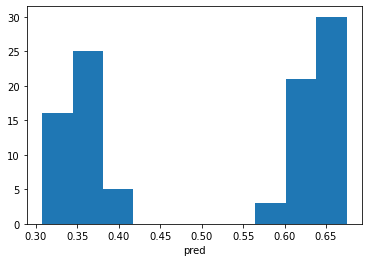

In [182]:
plt.hist(log_no_seq.predict_proba(x_no_seq)[:100, 1])
plt.xlabel("pred")
plt.savefig("../plots/lognoseq.png")

In [180]:
log_no_seq.predict_proba(x_no_seq)[:100, 1]

array([0.67032206, 0.65721181, 0.64544049, 0.34736965, 0.34230628,
       0.33769616, 0.3334819 , 0.6162533 , 0.62335258, 0.62969706,
       0.62031631, 0.61170943, 0.61780096, 0.61000041, 0.60277375,
       0.6085522 , 0.60190779, 0.60730935, 0.60116077, 0.31060443,
       0.31764617, 0.31402789, 0.31067933, 0.30757178, 0.31376614,
       0.59554584, 0.60066183, 0.60543822, 0.60990688, 0.60460445,
       0.32275477, 0.32862342, 0.33419621, 0.33949333, 0.63191581,
       0.63581131, 0.63947994, 0.64294054, 0.35866106, 0.35534318,
       0.35221269, 0.34925443, 0.3539565 , 0.35845559, 0.36276373,
       0.35979834, 0.36388615, 0.36781073, 0.36491226, 0.36865199,
       0.36585394, 0.36317857, 0.64815038, 0.64349887, 0.64664072,
       0.64962123, 0.64526897, 0.64815038, 0.64401706, 0.64004326,
       0.64286998, 0.63908077, 0.64181508, 0.63819429, 0.64084171,
       0.63737517, 0.34658738, 0.34417887, 0.34187053, 0.34525883,
       0.34301257, 0.62810901, 0.63071661, 0.63322219, 0.63563